In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


In [2]:
panda_path = '/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv'
image_dir = '/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'
val_path = '/kaggle/input/isic-2018/Skin_Disease_Full/labels.csv'
val_image_dir = '/kaggle/input/isic-2018/Skin_Disease_Full/Skin_Disease'

In [3]:
ground_truth = pd.read_csv(panda_path)
#ground_truth.drop('UNK', axis=1, inplace=True)

In [4]:
val_truth = pd.read_csv(val_path)

In [5]:
index = 0
for img in ground_truth.image:
    img = img+'.jpg'
    ground_truth.image[index]=img
    index += 1
    
index = 0
for img in val_truth.image:
    img += '.jpg'
    val_truth.image[index] = img
    index += 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [6]:
val_truth.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0024306.jpg,0,1,0,0,0,0,0,0,0
1,ISIC_0024307.jpg,0,1,0,0,0,0,0,0,0
2,ISIC_0024308.jpg,0,1,0,0,0,0,0,0,0
3,ISIC_0024309.jpg,0,1,0,0,0,0,0,0,0
4,ISIC_0024310.jpg,1,0,0,0,0,0,0,0,0


In [7]:
ground_truth.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
ground_truth.tail()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
25326,ISIC_0073247.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25330,ISIC_0073254.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
print(f'There are {len(os.listdir(image_dir))} many images in the train set')
print(f'There are {len(os.listdir(val_image_dir))} many images in the train set')

There are 25333 many images in the train set
There are 10015 many images in the train set


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout
import matplotlib.pyplot as plt

In [11]:
num_classes = ground_truth.columns.size
num_classes -= 1

In [12]:
model = Sequential()
model.add(ResNet50(weights='imagenet', input_shape=(224, 224, 3)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

102973440/102967424 [==============================] - 4s 0us/step


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                64064     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 585       
Total params: 25,701,361
Trainable params: 25,648,241
Non-trainable params: 53,120
_______________________________________

In [14]:
for layer in model.layers[0].layers:
    layer.trainable = False

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print('model has compiled')

model has compiled


In [16]:
labels = ground_truth.columns
labels = labels[1:]


In [17]:
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = data_gen.flow_from_dataframe(dataframe=ground_truth, directory=image_dir, x_col='image', target_size=(224, 224),
                                     y_col=labels, class_mode='raw', batch_size=64)
val_gen = data_gen.flow_from_dataframe(dataframe=val_truth, directory=val_image_dir, x_col='image', y_col=labels, class_mode='raw', batch_size=64)

Found 25331 validated image filenames.
Found 10015 validated image filenames.


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=2)

In [19]:
history = model.fit(train_gen, steps_per_epoch=25331//64, epochs=30, validation_data=val_gen, validation_steps=10015//64, callbacks=[callback])

Train for 395 steps, validate for 156 steps
Epoch 1/30
395/395 [==============================] - 735s 2s/step - loss: 1.5425 - accuracy: 0.5074 - val_loss: 1.1803 - val_accuracy: 0.6693
Epoch 2/30
395/395 [==============================] - 680s 2s/step - loss: 1.3248 - accuracy: 0.5335 - val_loss: 1.1723 - val_accuracy: 0.6619
Epoch 3/30
395/395 [==============================] - 652s 2s/step - loss: 1.2712 - accuracy: 0.5541 - val_loss: 1.1960 - val_accuracy: 0.6584
Epoch 4/30
395/395 [==============================] - 659s 2s/step - loss: 1.2468 - accuracy: 0.5612 - val_loss: 1.2061 - val_accuracy: 0.6543


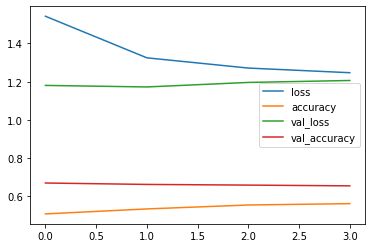

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.legend(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
plt.show()